<a href="https://colab.research.google.com/github/iIsunnyIi/PractisePro/blob/main/Global_Terrorism_Notebook_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data consists of over 170,000 cases of terrorism worldwide, documented from 1970 to 2016. Each tuple represents a terrorist attack. Let us see what we can infer from this data. We begin by importing the following libraries:
- **matplotlib**: Display graphs/charts
- **nltk**: Natural Langauge Processing Toolkit to deal with Text data.
- **numpy**: Python's library for mathematical operations
- **operator**: Only used once for dictionary sort
- **pandas**: Deals with data storage and manipulation in the form of Dataframes. 
- **Seaborn**: The library that generates the scatterplots, boxplots, histograms

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator
import pandas as pd
import seaborn as sns

from collections import Counter
from nltk.tokenize import PunktSentenceTokenizer
from nltk.chunk import RegexpParser

In [2]:
#Mount the drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
# /content/drive/MyDrive/kaggle is the path where kaggle.json is present in the Google Drive

In [10]:
#changing the working directory
cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [15]:
#Check the present working directory using pwd command
!pwd

/content/drive/My Drive/kaggle


In [11]:
#Go to kaggle and copy the API Command to download the dataset
#Your API Command will look like “kaggle datasets download -d START-UMD/gtd”
#Run the following code using ! :
!kaggle datasets download -d START-UMD/gtd

 77% 22.0M/28.7M [00:00<00:00, 226MB/s]
100% 28.7M/28.7M [00:00<00:00, 183MB/s]


In [16]:
#You can check the content in your directory using ls command as follows:
!ls

globalterrorismdb_0718dist.csv	kaggle.json


In [13]:
#unzipping the zip files and deleting the zip files
#Use the unzip and rm command
!unzip \*.zip  && rm *.zip

Archive:  gtd.zip
  inflating: globalterrorismdb_0718dist.csv  


In [ ]:
#That’s all folks …Now you can use the extracted .csv files with ease directly from your Google Drive.

In NLTK, we also include: 
- **PunctSentenceTokenizer:** to split a paragraph into constitutent sentences
- **RegexpParser:** To perform chunking of words and recognize key phrases. More on this later.

We now read the csv file into a Data Frame and display the first 5 rows for reference.

In [18]:
data = pd.read_csv('globalterrorismdb_0718dist.csv', encoding="ISO-8859-1", low_memory=False)
data.head(n=5)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,...,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,...,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,...,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.997490,23.762728,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,...,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,East Asia,Fukouka,Fukouka,33.580412,130.396361,1.0,0,NaN,NaN,1,1,1,-9.0,NaN,NaN,0.0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Consulate,...,NaN,NaN,Incendiary,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


I include a _low memory_ argument to prevent mixed types assigned to a given column. It is mostly advised to used the dtype argument and specify the type for each column name. However, since there are 135 columns, most of which I do not know much about, I'm going by the lazy approach and setting low_memory to False.

Pulling this data up on Excel, we see Half of them are numerically encoded column values while the others are Text forms of the same. Just looking at this data, I feel like I can answer a number of questions:
1. Where exactly have the terrorist attacks taken place?
2. In these regions, can we plot a time series chart to show how much terrorism has increased/decreased?
3. Analyze Text data summary, to understand some more details not specified by other columns.
4. What was the nature of the Terrorist attacks in a particular country/state over the years? (From attacktype_1, attacktype_2 and attacktype_3)
5. What/Who was the target of their assault? (targtype)
6. Can we get more details from 5? Like what _exactly_ was the type of institution being targetted? (targsubtype)
7. Analyze Text data on motive to understand why the terrorist attack was carried out.
8. What weapons were used in the assault? (weaptype1 - 4) Can we get more details on the exact weapons? (weapsubtype)
9. Overall Price of property destroyed? (propvalue)
10. Who were these terrorists? (gname)
11. What propery was actually destroyed? (propcomment)
12. In the kidnapping situations, were the hostages released? 
13. Analyze Text data on addnotes. What else can we infer from the data?

These are just a handful of questions I came up with off the top of my head. We can possibly find more information, given time. It is easy to get lost in this wealth of data. Instead of boiling the ocean at the surface, I will delve into a single aspect. So, where do we start? Let us take a look at the countries that are the most targetted.

In [19]:
freq_dist = data['country_txt'].value_counts()
freq_dist[freq_dist > 2000]

Iraq                        24636
Pakistan                    14368
Afghanistan                 12731
India                       11960
Colombia                     8306
Philippines                  6908
Peru                         6096
El Salvador                  5320
United Kingdom               5235
Turkey                       4292
Somalia                      4142
Nigeria                      3907
Thailand                     3849
Yemen                        3347
Spain                        3249
Sri Lanka                    3022
United States                2836
Algeria                      2743
France                       2693
Egypt                        2479
Lebanon                      2478
Chile                        2365
Libya                        2249
West Bank and Gaza Strip     2227
Syria                        2201
Russia                       2194
Israel                       2183
Guatemala                    2050
South Africa                 2016
Name: country_

At the top of the list, we have Iraq with over $22,000$ documents cases of terrorism. Let us focus on Terrorist attacks in Iraq. On to the next question: Who exactly is responsible for these attrocities in Iraq?

In [20]:
iraq_data = data[ data['country_txt'] == 'Iraq' ]
iraq_data['gname'].value_counts()[:10]

Unknown                                        18520
Islamic State of Iraq and the Levant (ISIL)     4797
Al-Qaida in Iraq                                 632
Islamic State of Iraq (ISI)                      145
Asa'ib Ahl al-Haqq                                67
Gunmen                                            57
Tawhid and Jihad                                  49
Al-Naqshabandiya Army                             35
Muslim extremists                                 32
Ansar al-Islam                                    28
Name: gname, dtype: int64

Here is a list of the Top 10 most active groups. Islamic State of Iraq and the Levant (ISIL) or ISIS tops this list.

**Objective**: In this report, we will see what can be inferred about ISIL's actions in Iraq. I chose ISIS because it is easy to verify our findings through online sources. Lets start answering questions one at a time.

In [21]:
isis_iraq_data = iraq_data[iraq_data['gname'] == 'Islamic State of Iraq and the Levant (ISIL)']

_How has ISIS's influence varied over the years in Iraq?_

In [22]:
data = isis_iraq_data['iyear'].value_counts()
data

2016    1206
2017    1154
2014    1100
2015     996
2013     341
Name: iyear, dtype: int64

At first, I found it strange as ISIS had it's first attacks in Iraq in 2013. After all, It was established in 1999, so you would expect some cases in Iraq before then. But I found out they refered to themselves by different names over the years. In April 2013,  _Islamic State of Iraq and the Levant_ or the modern ISIL was founded [1]. Their activity is clearly on the incline. 

_How many people has ISIS killed over the years in Iraq? Has it increases/decreased?_

In [23]:
for year in range(2013,2017):
    num_kills = sum(isis_iraq_data['nkill'][isis_iraq_data['iyear'] == year].dropna())
    print("Number of kills by ISIL in Iraq in ", year, " = ", num_kills)

Number of kills by ISIL in Iraq in  2013  =  1347.0
Number of kills by ISIL in Iraq in  2014  =  8604.0
Number of kills by ISIL in Iraq in  2015  =  5976.0
Number of kills by ISIL in Iraq in  2016  =  9528.0


Clearly, ISIL has become more active in number of attacks and fatalities.

_What kind of attacks does ISIL usually go with in Iraq?_

In [24]:
isis_iraq_data['attacktype1_txt'].value_counts()

Bombing/Explosion                      3201
Unknown                                 635
Hostage Taking (Kidnapping)             463
Armed Assault                           339
Assassination                           100
Facility/Infrastructure Attack           41
Hostage Taking (Barricade Incident)      14
Hijacking                                 4
Name: attacktype1_txt, dtype: int64

Looks like they are a fan of Bombs and Explosives. They used this method of attack for nearly **two-thirds** of their attacks in Iraq. Hostage Taking is also common in the form of Kidnapping. Barricading involves trapping a group of people. It is harder to accomplish, which is probably why it also is not a common method of attack.

Let us take a look at the $12$ barricade incidents.

In [25]:
isis_iraq_data[['success' ,'nkill', 'provstate']][isis_iraq_data['attacktype1_txt'] == 'Hostage Taking (Barricade Incident)']

,success,nkill,provstate
118797,1,5.0,Babil
122408,1,4.0,Al Anbar
124274,1,3.0,Kirkuk
124975,1,9.0,Saladin
126594,1,24.0,Baghdad
128283,1,9.0,Saladin
130625,1,9.0,Baghdad
133051,1,2.0,Al Anbar
142423,1,3.0,Diyala
143749,1,0.0,Kirkuk


We'll also plot a histogram while we are at it.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


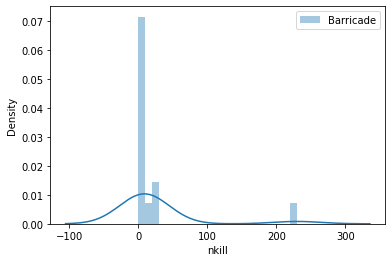

In [26]:
barricade = isis_iraq_data['nkill'][isis_iraq_data['attacktype1_txt'] == 'Hostage Taking (Barricade Incident)']
sns.distplot(barricade, label="Barricade")

plt.legend()
plt.show()

Looks like all barricade attempts were a success. Baghdad seemed to be hit pretty hard by these type of attacks. 

_Who were the targets for the Kidnappings?_

In [27]:
isis_iraq_data['targtype1_txt'][isis_iraq_data['attacktype1_txt'] == 'Hostage Taking (Kidnapping)'].value_counts()

Private Citizens & Property       282
Police                             61
Military                           50
Journalists & Media                18
Terrorists/Non-State Militia       16
Government (General)               14
Business                            9
Religious Figures/Institutions      6
Educational Institution             3
Violent Political Party             1
Government (Diplomatic)             1
Transportation                      1
Utilities                           1
Name: targtype1_txt, dtype: int64

Private Citizens, the Police and Military are their primary targets. Can we get some intel on what _Private Citizens & Property_ represents?

In [28]:
isis_iraq_data['targsubtype1_txt'][(isis_iraq_data['targtype1_txt'] == 'Private Citizens & Property') & (isis_iraq_data['attacktype1_txt'] == 'Hostage Taking (Kidnapping)') ].value_counts()

Unnamed Civilian/Unspecified                                    183
Alleged Informant                                                30
Village/City/Town/Suburb                                         18
Laborer (General)/Occupation Identified                          14
Religion Identified                                               8
House/Apartment/Residence                                         8
Race/Ethnicity Identified                                         6
Political Party Member/Rally                                      5
Named Civilian                                                    4
Farmer                                                            2
Procession/Gathering (funeral, wedding, birthday, religious)      1
Student                                                           1
Protester                                                         1
Refugee (including Camps/IDP/Asylum Seekers)                      1
Name: targsubtype1_txt, dtype: int64

Of the specified Kidnapping of Citizens, we had 25 cases involving General Laborers. _Who exactly constituted these targetted labourers?_

In [29]:
isis_iraq_data['target1'][ (isis_iraq_data['targsubtype1_txt'] == 'Laborer (General)/Occupation Identified') & (isis_iraq_data['targtype1_txt'] == 'Private Citizens & Property') & (isis_iraq_data['attacktype1_txt'] == 'Hostage Taking (Kidnapping)') ].value_counts()

Suspected Security Collaborators                              2
Former Islamic State of Iraq and the Levant (ISIL) Members    1
Al-Sada al-Na'im Tribal Chief: Talib Ibrahim al-'Ali          1
Leader of Albu-Riyash Clan: Sheikh Mahmud Nazim al-Kaka       1
Traders; Truck Drivers                                        1
Al Jabur Tribe Chief: Ibrahim Nayif al-Muhayri                1
Medical Team Members                                          1
Surgeons                                                      1
Mechanical Engineer: Zakariyah Ali Taha                       1
Doctors: Maha Sabhan, Lamia Ismail                            1
Tribal Chieftains                                             1
Tribal Leader: Shaykh Muzhir Muhammad al-Mashuh al-Jumayli    1
Preacher                                                      1
Name: target1, dtype: int64

So The most "documented" targetted individuals were suspected spies and informants. I used the term _documented_ because 150 of 200 Private Citizens and propery targeted are unknown. 

_How does ISIL deal with other Terrorist groups and Non-State Militia?_

In [30]:
isis_iraq_data['attacktype1_txt'][ (isis_iraq_data['targtype1_txt'] == 'Terrorists/Non-State Militia')].value_counts()

Bombing/Explosion              75
Unknown                        29
Armed Assault                  22
Hostage Taking (Kidnapping)    16
Assassination                   9
Name: attacktype1_txt, dtype: int64

They deal with them like any other: Bombs, Armed Assault, Kidnapping and assassination. 

_Among their terrorist enemies, who do they assassinate?_

In [31]:
targets = isis_iraq_data[['target1']][ (isis_iraq_data['attacktype1_txt'] == 'Assassination') & (isis_iraq_data['targtype1_txt'] == 'Terrorists/Non-State Militia') ]
targets.apply( lambda x: x.str.split(':')[0][0] , axis=1).value_counts()

House of Leader        3
Leader                 2
Convoy of Commander    1
Member                 1
Commander              1
Vehicle of Leader      1
dtype: int64

Positions of Leader and Commander are targets for assassination.

_Who are these other terrorist groups/ Militias?_

This will involve some _Natural Langauge Processing_. I create a function which takes 2 arguements:
- **text**: The textual paragraph to be analyzed.
- **regex**: The type of Keyphrases to look out for

Initially, I combine all the content in the _summary_ column that describes the terrorist attacks on other Terrorists and Non-State Militia. This text is passed into the function which performs the following sequence of actions:
1. **Word Tokenization**: Breaks the passage into constituent words.
2. **Part of Speech Tagging**: Tag elements based on part of speech. A list of possible POS tags in [2]. 
3. **Chunk Unit**: They are the phrases you wish to recognize. I only consider phrases grater longer than bigrams, that is more than 2 word phrases.
4. **Frequency Distribution**: Determine the frequency of occrrence of such phrases. The most common are your _key_ prases.

I wrapped these 4 stages in a function so that we can reuse them for other NLP tasks.

In [33]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [37]:
def text_manipulation(text, regex):
    words = nltk.word_tokenize(text.lower())
    tagged = nltk.pos_tag(words)

    chunkGram = regex
    
    chunkParser = RegexpParser(chunkGram)
    chunked = chunkParser.parse(tagged)

    candidate_keywords = []
    for tree in chunked.subtrees():
        if (tree.label() == 'PHRASE') and (len(tree.leaves()) >= 2):
            candidate_keyword = ' '.join([x for x,y in tree.leaves()])
            candidate_keywords.append(candidate_keyword)

    return Counter(candidate_keywords)
    
text = ' '.join(isis_iraq_data['summary'][isis_iraq_data['targtype1_txt'] == 'Terrorists/Non-State Militia'].dropna().tolist())
common_phrases = text_manipulation(text, r""" PHRASE: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}""")
for x,y in sorted(common_phrases.items(), key=operator.itemgetter(1), reverse=True):
    if y>=2:
        print((x,y))

('islamic state of iraq', 134)
('saladin governorate', 33)
('volunteer fighters', 32)
('explosive device', 31)
('suicide bomber', 22)
('state of iraq', 19)
('explosives-laden vehicle', 15)
('al anbar', 14)
('diyala governorate', 13)
('security forces', 13)
('same day', 12)
('baghdad city', 11)
('baghdad governorate', 11)
('sahwa council members', 8)
('coordinated attacks', 8)
('suicide bombers', 8)
('sahwa council leader', 7)
('al anbar governorate', 7)
('sahwa member', 6)
('sahwa council member', 6)
('babil governorate', 6)
('sahwa members', 5)
('other people', 4)
('militia members', 4)
('volunteer forces', 4)
('reported casualties', 3)
('same night', 3)
('security members', 3)
('explosives-laden vehicles', 3)
('unknown number of assailants', 3)
('volunteer fighter commander', 3)
('ramadi city', 2)
('sahwa council building in daquq district', 2)
('family members', 2)
('samarra district', 2)
('tikrit city', 2)
('volunteer fighters in baiji district', 2)
('sahwa council checkpoint in ar

Looks like these Terrorist Groups & Militias they targeted include iraqi volunteer forces, volunteer fighters in arab ebjur area,baiji district and bashir. The names of Specific Militia are not mentioned in the summary. 

_Can we get more info on the nature of attack?_

To get more information about the attacks on ISIL's association with Terrorist Groups/Militias, we parse the "summary" column and see what we can find. I am looking for information along the lines of "X killed Y" or "X was killed". If we were to perform Part of Speech tagging, the equivalent chunking unit would be "The big bad wolf killed the lazy fox". 

In [38]:
text = "The big bad wolf killed the lazy fox"
words = nltk.word_tokenize(text)
nltk.pos_tag(words)

[('The', 'DT'),
 ('big', 'JJ'),
 ('bad', 'JJ'),
 ('wolf', 'NN'),
 ('killed', 'VBD'),
 ('the', 'DT'),
 ('lazy', 'NN'),
 ('fox', 'NN')]

So I use a similar sequence of POS tags for creating chunks : $<JJ>? <NN.*>+ <VB.*>+ <DT>? <JJ>? <NN.*>+ $

In [39]:
text = ' '.join(isis_iraq_data['summary'][isis_iraq_data['targtype1_txt'] == 'Terrorists/Non-State Militia'].dropna().tolist())
common_phrases = text_manipulation(text, r""" PHRASE: {<JJ>? <NN.*>+ <VB.*>+ <DT>? <JJ>? <NN.*>+ }""")
for x,y in sorted(common_phrases.items(), key=operator.itemgetter(1), reverse=True):
    if y>=2:
        print((x,y))

('group claimed responsibility', 68)
('sources attributed the attack', 60)
('suicide bomber detonated an explosives-laden vehicle', 12)
('assailants opened fire', 11)
('assailants attacked volunteer fighters', 10)
('security forces repelled the assault', 7)
('explosive device detonated targeting a volunteer fighter patrol', 5)
('assailants fired mortars', 4)
('assailants attacked a sahwa council checkpoint', 3)
('suicide bomber detonated targeting volunteer fighters', 3)
('explosive device detonated targeting a vehicle', 3)
('assailants attacked militia members', 3)
('sources attributed the attacks', 3)
('assailants detonated an explosive device', 2)
('assailants stormed the residence', 2)
('explosive device detonated targeting volunteer fighters', 2)
('sources attributed the incident', 2)
('assailants attacked a checkpoint', 2)
('assailants planted explosive devices', 2)
('assailants attacked volunteer forces', 2)
('assailants fired rockets', 2)
('assailants kidnapped an unknown numbe

A common method of dealing with these Militias is through detonation of an explosives-laden vehicle. Another tactic is through suicide bombers either in a vehicle or stapping bombs to their person. Not all attacks went successful as we see security forces repelled the assault.

_So why did ISIL attack parts of Iraq?_

In other words, we need to explore the _motive_.The recommended way of looking for key phrases in the motive would be trying to chunk words according to a pattern like we did before.

In [40]:
text = ' '.join(isis_iraq_data['motive'].dropna().tolist())
common_phrases = text_manipulation(text,  r""" PHRASE: {<VB> <DT>? <NN.*>+ (<CC> <NN*>+)? <IN>? <NN.*>+}""")
for x,y in sorted(common_phrases.items(), key=operator.itemgetter(1), reverse=True):
    if y>=1:
        print((x,y))

('iraqi security forces', 23)
('punish the police officer', 10)
('distract security personnel', 3)
('reclaim parts of mosul', 3)
('start rumors that security personnel', 3)
('locate militants in iraq', 2)
('islamic state of iraq', 2)
('distract security forces from operations', 2)
('divert security forces', 2)
('kurdish militias in syria', 1)
('fight sunni muslims', 1)
('allow security force', 1)
('combat idolatry and disbelief in iraq', 1)
('al anbar governorate', 1)
('divert the attention of security personnel', 1)
('issue death sentences against individuals', 1)
('keep the information secret', 1)


On closer inspection of the motives, however we see that many of them are similar, word for word.So we could get away with a direct frequency distribution. This approach is very specific to the current dataset.

In [41]:
isis_iraq_data['motive'].dropna().value_counts()[:10]

The specific motive is unknown; however, sources noted that the victims were attempting to leave the area at the time of the attack.                                                                                                                                                                                                                                                                    24
According to an online statement, Islamic State of Iraq and the Levant (ISIL) claimed responsibility for the incident, stating that the attack was in retaliation for the Iraqi government's alleged "crimes" against the minority Sunni community. Moreover, the armed Islamist outfit claims that the incident was part of its newly launched offensive campaign called "Harvesting the Soldiers".    23
In a statement posted online, Islamic State of Iraq and the Levant (ISIL) claimed responsibility and stated that the attacks were in response to Iraqi security forces arresting hundreds of Muslims.             

In the statements above, Baghdad seems to be a ceter location. In 30 cases, ISIL states the bombings in and around baghdad was retaliation for intensified security operations against insurgents in Sunni areas.

_Who are ISIL's targets in Baghdad?_

In [42]:
isis_iraq_data[['target1', 'success','attacktype1_txt']][isis_iraq_data['motive'].str.contains('Baghdad', regex=True, na=False)]

,target1,success,attacktype1_txt
118628,Car Dealership,1,Bombing/Explosion
118629,Civilians,1,Bombing/Explosion
119257,Civilians,1,Bombing/Explosion
120850,Restaurants,1,Bombing/Explosion
120851,Restaurants,1,Bombing/Explosion
120852,Restaurants,1,Bombing/Explosion
120853,Shia Neighborhood,1,Bombing/Explosion
120854,Police Station,1,Bombing/Explosion
120855,Ice Cream Shop,1,Bombing/Explosion
120856,Shia Civilians,1,Bombing/Explosion


From the data, we observe the Siite Neighborhood and civilians are ISIL's targets.

_Let us take a look at the most targeted states/provinces in Iraq by ISIL_

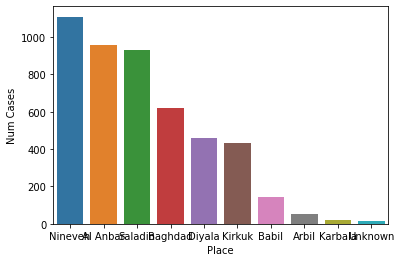

In [43]:
data = dict(isis_iraq_data['provstate'].value_counts())
x = list(data.keys())
y = list(data.values())
d = pd.DataFrame({'Place':x, 'Num Cases':y})

sns.barplot(data=d[:10], x='Place', y='Num Cases') #Display top 10
plt.show()

The graph above displays the cities with the most number of terror attacks by ISIL. 
_What about Number of kills since ISIL's founding in 2013?_

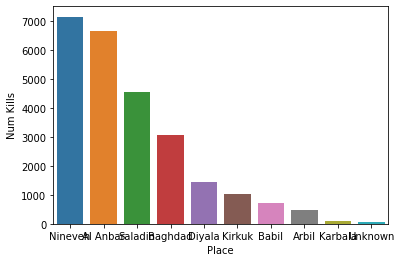

In [44]:
data = pd.DataFrame(columns=['Place', 'Num Kills'])

i=0
for place in isis_iraq_data['provstate'].unique():
    num_kills = 0
    
    for year in range(2013,2017):
        num_kills += sum(isis_iraq_data['nkill'][(isis_iraq_data['iyear'] == year) & (isis_iraq_data['provstate'] == place)].dropna())
        
    data.loc[i] = [place, num_kills]
    i+=1
        
data = data.sort_values(by='Num Kills', ascending=False) 
sns.barplot(data=data[:10], x='Place', y='Num Kills') #Display top 10
plt.show()

Looks like Al Anbar, Nineveh, Saladin & Baghdad suffer the most fatalities with at least $3,000$ lives claimed in each city since 2013 by ISIL.

_How has the number of fatalities varied over the course of 4 years: 2013-2016?_

In [45]:
data = pd.DataFrame(columns=['Place', '2013', '2014', '2015', '2016', 'Total Kills'])

i=0
for place in isis_iraq_data['provstate'].unique():
    num_kills = []
    
    for year in range(2013,2017):
        num_kills.append(sum(isis_iraq_data['nkill'][(isis_iraq_data['iyear'] == year) & (isis_iraq_data['provstate'] == place)].dropna()))
        
    data.loc[i] = [place, num_kills[0], num_kills[1], num_kills[2], num_kills[3], sum(num_kills)]
    i+=1
        
data = data.sort_values(by='Total Kills', ascending=False) 
data

,Place,2013,2014,2015,2016,Total Kills
3,Nineveh,100.0,2762.0,570.0,3728.0,7160.0
5,Al Anbar,61.0,1374.0,2829.0,2405.0,6669.0
2,Saladin,222.0,2290.0,947.0,1082.0,4541.0
0,Baghdad,561.0,936.0,601.0,956.0,3054.0
4,Diyala,182.0,538.0,548.0,175.0,1443.0
14,Kirkuk,38.0,185.0,273.0,546.0,1042.0
1,Babil,78.0,378.0,45.0,225.0,726.0
10,Arbil,14.0,11.0,151.0,284.0,460.0
13,Karbala,13.0,42.0,0.0,56.0,111.0
18,Unknown,0.0,58.0,2.0,0.0,60.0


For easier comparison, we will construct a multi-bar plot. Pandas constructs such plots by initially reshaping the dataframe using pandas' _melt_ method [3]. 

This function increases the number of rows and combines columns 2013 to 2016 under a common _Year_ banner. I have displayed the example output of the function after excluding some minor cities.

In [46]:
df = pd.melt(data, id_vars="Place", var_name="Year", value_name="Kill Count")
places = df[ (~df['Place'].isin(['Wasit', 'Basra', 'Dhi Qar', 'Najaf', 'Maysan', 'Muthanna','Kirkuk', 
                                 'Al Qadisiyah', 'NIneveh', 'Sulaymaniyah','Unknown', 'Dihok'])) & 
             (~df['Year'].str.contains('Total Kills'))] #Exclude certain places

df[:30] #Just the first 30 entries for understanding

,Place,Year,Kill Count
0,Nineveh,2013,100.0
1,Al Anbar,2013,61.0
2,Saladin,2013,222.0
3,Baghdad,2013,561.0
4,Diyala,2013,182.0
5,Kirkuk,2013,38.0
6,Babil,2013,78.0
7,Arbil,2013,14.0
8,Karbala,2013,13.0
9,Unknown,2013,0.0


Since there are going to be a ton of bar graphs on a single graph, I resize the chart using matplotlib's pyplot. At the time of writing this post, there is no way to vary plot sizes in seaborn.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


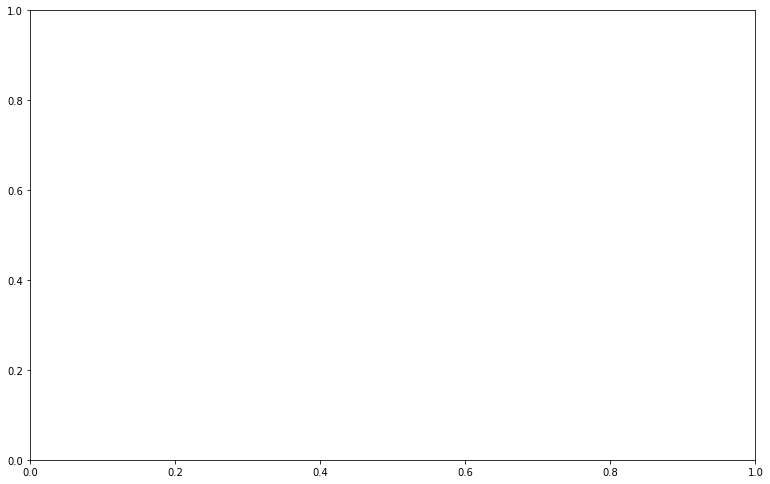

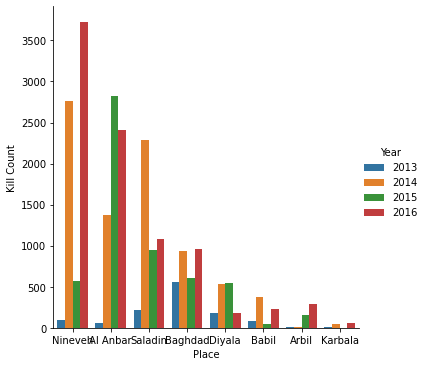

In [47]:
# Make the plot bigger
a4_dims = (13, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.factorplot(x='Place', y='Kill Count', hue='Year', data=places, kind='bar', ax=ax)
plt.show()

Although the total number of fatalities in Nineveh is less than that in Al Anbar, many more people died in Nineveh than any other city by far in 2016. Al Anbar actually saw more fatalities in the previous year.

We can go on answering questions by analyzing data for a single Terror group in a single country. Thought this was a better approach than just getting a partial birdseye view of the data.

## References

[1]  [Timeline of ISIL Related Events](https://en.wikipedia.org/wiki/Timeline_of_ISIL-related_events)

[2]  [List of part of speech tagging terms](https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/)

[3]   [Seaborn: Multiple barplots](https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots)